# Определение рейтинга шоколада

Проект является решением для соревнования https://www.kaggle.com/competitions/practical-ml-chocolate/overview  в рамках курса "Практический Machine Learning" https://stepik.org/course/125501/info

Решается задача определения рейтинга шоколада. Датасет содерхжит информацию о следующих характеристиках шоколадок:

- Company - компания производитель
- Specific Bean Origin - географический регион происхождения
- REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
- Review - дата публикации отзыва
- Cocoa Percent - процентное содержание какао
- Company Location - страна производитель
- Rating - экспертный рейтинг
- Bean Type - используемый сорт какао-бобов, если таковой имеется
- Broad Bean Origin - географический регион происхождения какао-бобов

Система рейтинга шоколада:
- 5 = Elite
- 4 = Premium
- 3 = Satisfactory(3.0) to praiseworthy(3.75)
- 2 = Disappointing
- 1 = Unpleasant

**Никнейм на Kaggle**: Alena Kniazeva (https://www.kaggle.com/alenakn)

**Достигнутый score на тестовых данных: 0.21911**

## 1. Импорт библиотек и загрузка данных

In [1]:
#!pip install association-metrics

In [2]:
#!pip install category_encoders

In [31]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import optuna
import shap

import association_metrics as am

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings("ignore") 

In [4]:
RANDOM_STATE=42
N_FOLDS = 5

In [5]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [6]:
train_df = pd.read_csv(TRAIN)

## 2. Исследовательский анализ данных

In [7]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Обработаем признак `Cocoa Percent`: удалим знак процента и преобразуем к вещественному типу

In [8]:
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].map(lambda x: x.rstrip('%'))
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].astype('float64')

Видим, что признак `Bean Type` для некоторых объектов отсутствует. Проверим, каким значением представлены эти пропуски и заменим во всем датафрейме это значение на строку "Unknown"

In [9]:
str(train_df.loc[2, ['Bean Type']])

'Bean Type    \xa0\nName: 2, dtype: object'

In [10]:
train_df = train_df.replace(to_replace=u'\xa0', value='Unknown')

Проверим общую информацию о тренировочном датасете

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB


Обучающий датасет содержит **1255 объектов**, **8 признаков**, а также целевую переменную - `Rating`.

Из 8 признаков **3 имеют численные значние**, остальные **5 - текстовые**.

Целевая переменная - **вещественная**. Т.о. решаем задачу регрессии

В признаках `Bean Type` и `Broad Bean Origin` есть по одному пропуску. Чтобы не терять эти данные заменим пропущенные значения на строку "Unknown"

In [12]:
train_df.fillna('Unknown', inplace=True)

### 2.1. Исследование числовых признаков

Проверим корреляцию числовых признаков с таргетом

In [13]:
num_features = ['REF', 'Review', 'Cocoa Percent', 'Rating']
corr = train_df[num_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,REF,Review,Cocoa Percent,Rating
REF,1.000000,0.984938,0.045015,0.112792
Review,0.984938,1.000000,0.045322,0.111826
Cocoa Percent,0.045015,0.045322,1.000000,-0.172411
Rating,0.112792,0.111826,-0.172411,1.000000


Видим, что числовые признаки слабо коррелируют с целевой переменной.

При этом сильно коррелируют признаки `REF` и `Review`. **Будем учитывать это при построении моделей  либо при необходимости удалим один из этих признаков**.

Проверим числовые признаки и целевую переменную на наличие выбросов. Построим boxplots

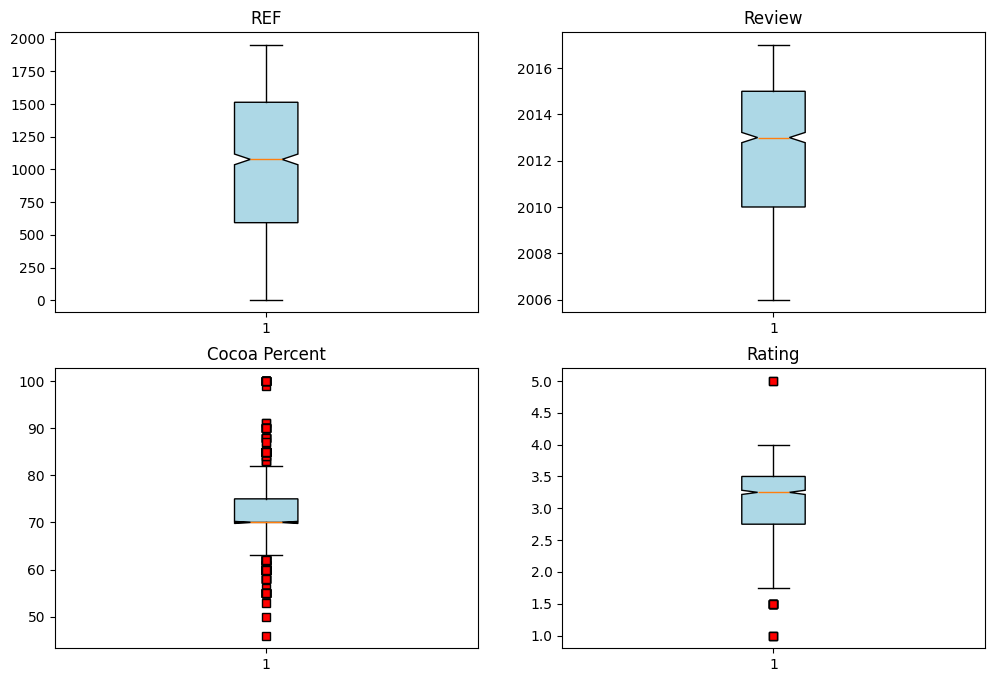

In [14]:
fig, a = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.2)

for i in range(2):
    for j in range(2):
        a[i][j].set_title(num_features[i*2+j])
        a[i][j].boxplot(train_df[num_features[i*2+j]], 
                        notch = True, 
                        flierprops = dict(marker = "s", markerfacecolor = "red"), 
                        patch_artist = True, 
                        boxprops = dict(facecolor = "lightblue")) 

При том,что по признаку `Cocoa Percent` и целевой переменной есть выбросы, их нельзя назвать аномалиями, т.к. они находятся в допустимых пределах. Поэтому пока что ничего удалять не будем

В рамках данного проекта будем работать с бустинговыми моделями поэтому **не будем выполнять масштабирование данных**, т.к. модели на основе деревьев нечувствительны к масштабированию

### 2.2. Исследование с текстовыми данными

Проверим количество уникальных значений в признаках с типом `object`

In [15]:
train_df.describe(include='object')

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1255
unique,376,762,58,38,84
top,Soma,Madagascar,U.S.A.,Unknown,Venezuela
freq,35,39,521,629,144


Проверим корреляцию категориальных/текстовых признаков. В качестве показателя применим V-меру Крамера

In [16]:
cat_df = train_df.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(cat_df)

cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.616841,0.603604
Specific Bean Origin,0.771074,1.000000,0.808500,0.907956,0.983377
Company Location,0.999651,0.808500,1.000000,0.291616,0.383218
Bean Type,0.616841,0.907956,0.291616,1.000000,0.388127
Broad Bean Origin,0.603604,0.983377,0.383218,0.388127,1.000000


Из полученных результатов видим, что **категориальные признаки достаточно сильно взаимосвязаны**, особенно `Company` и `Company Location`

В паре признаков  `Company` и `Company Location` сложно однозначно определить, что имеет большее значение: конкретный производитель или достаточно того, в какой стране компания-производитель находится. Построим 2 графика распраделения рейтинга в зависимости от остальных данных, выделив цветом объекты на одном графике по признаку `Company Location`, на втором - по признаку `Company`

In [17]:
y_train = train_df['Rating']
X_train = train_df.drop('Rating', axis=1)

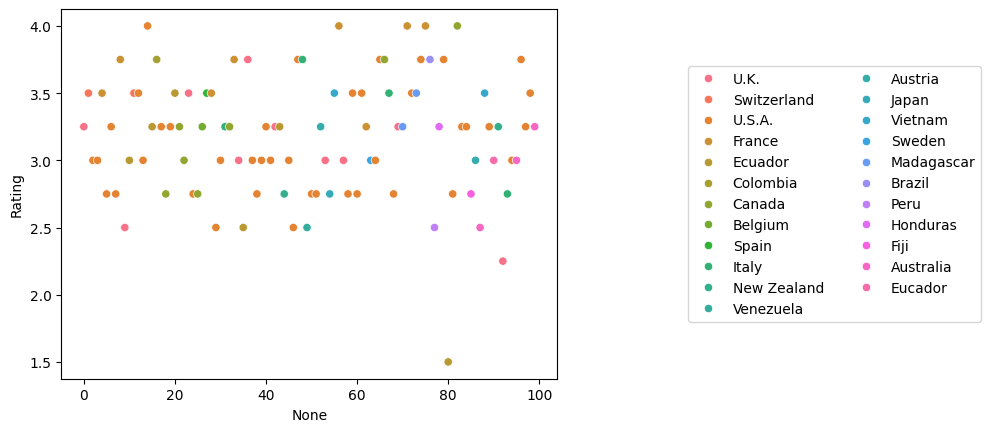

In [18]:
import seaborn as sns

g = sns.scatterplot(data=train_df.iloc[:100], x=X_train.iloc[:100].index, y=y_train[:100], hue='Company Location')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2)

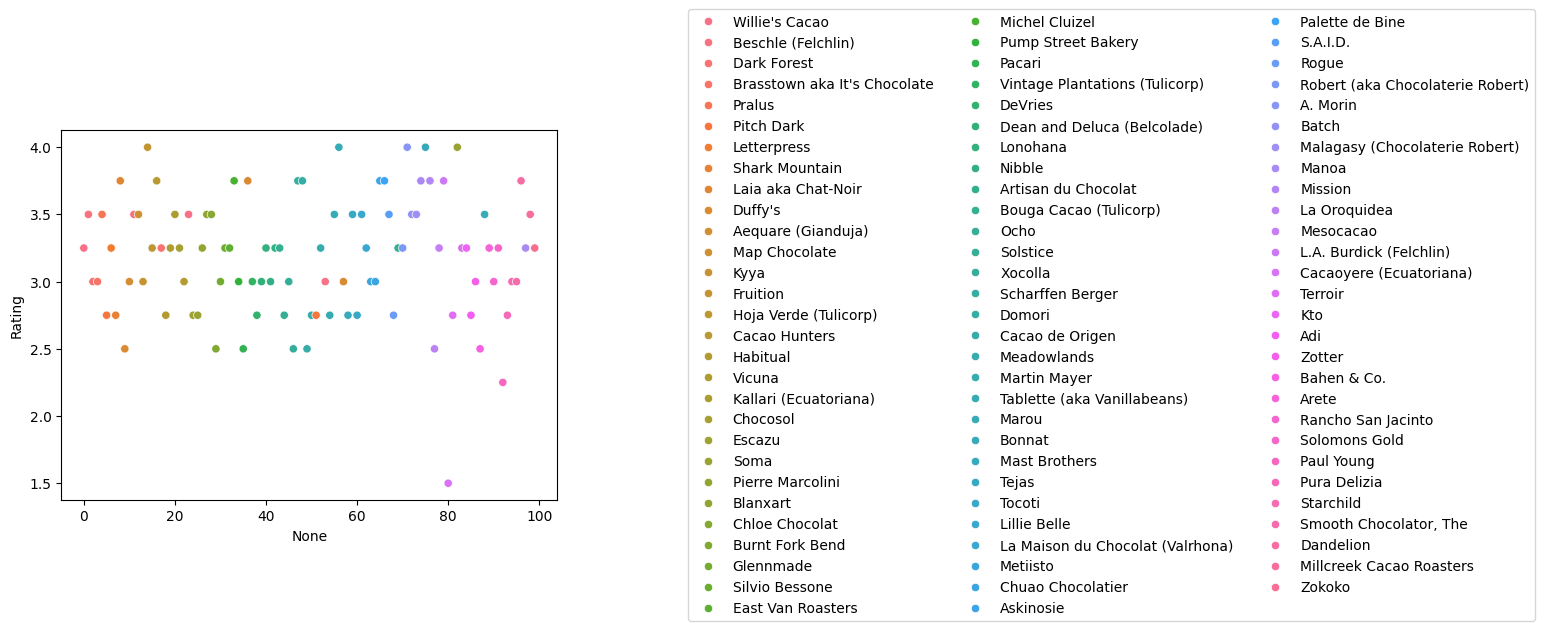

In [19]:
g2 = sns.scatterplot(data=train_df.iloc[:100], x=X_train.iloc[:100].index, y=y_train[:100], hue='Company')
g2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)

Из полученных результатов видим, что по признаку `Company` данные разделяются гораздо лучше, но и для признака `Company Location` тоже можно увидеть некоторые тенденции (например, достаточно "кучный" рейтинг шведского шоколада). Но при этом количество значений у данного признака (376 значений) значительно превышает количество значений для признака `Company Location` (56 значений). С учетом отмеченного оставим пока оба признака, несмотря на их сильную взаимосвязь

Также следует отметить, что **в данном проекте будем в основном применять бустинговые модели**, которые являются достаточно устойчивыми к коррелирующим признакам.

Проверим распределение целевой переменной

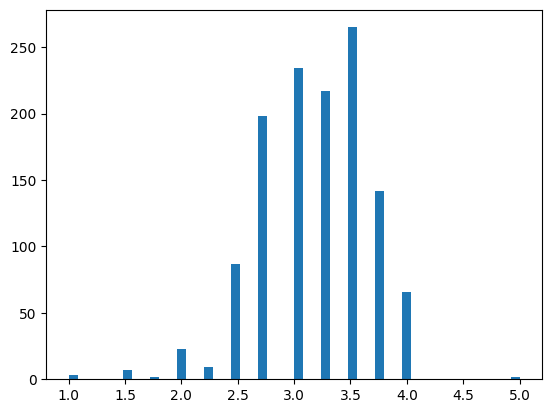

In [20]:
plt.hist(y_train, bins=50);

Полученное распределение в целом напоминает нормальное, так что дополнительных преобразований делать не надо

## 3. Baseline модель (CatBoost c параметрами по умолчанию)

Определим, какие признаки будем считать категориальными. Сначала выведем типы данных признаков

In [21]:
X_train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int64
Cocoa Percent           float64
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

Все признаки с типом `object` отнесем к категориальным. У признака `REF` достаточно много значений и его целесообразно отнести к численным. Признаки `Review` и `Cocoa Percent` могут рассматриваться также как категориальные. Создадим 4 набора индексов категориальных признаков (с/без `Review` и `Cocoa Percent`) и проверим качество baseline модели (в качестве таковой возьмем CatBoost c большинством параметров по умолчанию) на этих 4 наборах категориальных признаков

Единственная особенность состоит в том, что категориальными признаками в CatBoost могут быть либо тескстовые данные, либо целые числа. Поэтому умножим `Cocoa Percent` на 10 и преобразуем в целочисленные данные

In [22]:
X_train['Cocoa Percent'] = (X_train['Cocoa Percent'] * 10).astype('int64')

In [23]:
cat_features_index = []
# Review и Cocoa Percent категориальные
cat_features_index.append([0, 1, 3, 4, 5, 6, 7])
# Review категориальный, Cocoa Percent - нет
cat_features_index.append([0, 1, 3, 5, 6, 7])
# Review не категориальный, Cocoa Percent - категориальный
cat_features_index.append([0, 1, 4, 5, 6, 7])
# Review и Cocoa Percent не категориальные
cat_features_index.append([0, 1, 5, 6, 7])

In [24]:
for indexes in cat_features_index:
    model_catboost_default = CatBoostRegressor(cat_features=indexes, random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
    score = cross_val_score(model_catboost_default, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                            scoring='r2', verbose=0).mean()
    print(f'Cross-validation score for cathegorical indexes {indexes} is equal to {score}')

Cross-validation score for cathegorical indexes [0, 1, 3, 4, 5, 6, 7] is equal to 0.1511009214307972
Cross-validation score for cathegorical indexes [0, 1, 3, 5, 6, 7] is equal to 0.207048890746352
Cross-validation score for cathegorical indexes [0, 1, 4, 5, 6, 7] is equal to 0.1508126971425096
Cross-validation score for cathegorical indexes [0, 1, 5, 6, 7] is equal to 0.19926953998207708


Из полученных результатов видим, что включение помимо текстовых признаков в категориальные признаки `Review` несколько улучшить модель. В остальных случаях она хуже

Зафиксируем категориальные признаки, обучим baseline модель (CatBoost c параметрами по умолчанию) и проверим ее качество на тестовых данных

In [25]:
cat_features_index = [0, 1, 3, 5, 6, 7]
cat_features = list(X_train.columns[cat_features_index])

In [26]:
model_catboost_default = CatBoostRegressor(cat_features=cat_features_index, random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
model_catboost_default.fit(X_train, y_train)

Построим диаграмму feature importance для нашей baseline модели

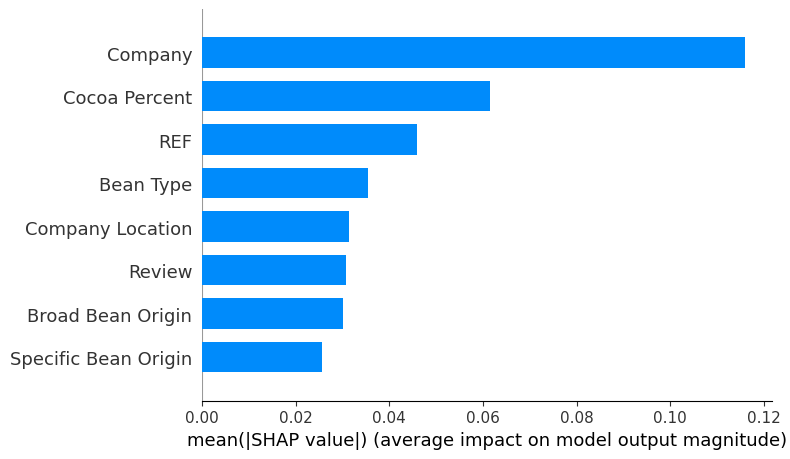

In [30]:
shap.initjs()
explainer = shap.TreeExplainer(model_catboost_default)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features_index))
shap.summary_plot(shap_values, X_train, plot_type="bar")

Выполним **предобработку тестовых данных**

In [62]:
X_test = pd.read_csv(TEST)
# обрабатываем 'Cocoa Percent' и переводим в числовой формат
X_test['Cocoa Percent'] = X_test['Cocoa Percent'].map(lambda x: x.rstrip('%'))
X_test['Cocoa Percent'] = X_test['Cocoa Percent'].astype('float64')
# обрабатываем пропуски
X_test = X_test.replace(to_replace=u'\xa0', value='Unknown')
# обрабатываем 'Cocoa Percent' (для единообразия)
X_test['Cocoa Percent'] = (X_test['Cocoa Percent'] * 10).astype('int64')

In [63]:
pred = model_catboost_default.predict(X_test)

In [64]:
test_df = X_test.copy()
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred
test_df[['id','Rating']].to_csv("catboost_default.csv", index=False)

**R2_score на тестовой выборке 0.18184**

## 4. Отбор и проектирование признаков

Теперь, когда есть неплохая baseline модель проанализируем еще раз признаки, которые в нее вошли на предмет возможности/целесообразности исключения Ранее в ходе исследовательского анализа данных была установлена сильная корреляция между признаками `REF` и `Review`. В ходе построения baseline модели было принято решение обрабатывать эти признаки по-разному: `REF` как числовой, а `Review` как категориальный. С учетом этого, а также того, что бустинговые модели, как правило, устойчивы к проблемам мультиколинеарности, оставим оба эти признака.

Также была установлена сильная взаимосвязь признаков `Company` и `Company Location`. Анализ важности признаков показал, что признак Company играет ключевую роль в оценке. Попробуем исключить признак `Company Location` и проверим качество полученной модели на кросс-валидации

In [33]:
XX_train = X_train.copy()
XX_train.drop(['Company Location'], axis=1, inplace=True)

In [36]:
XX_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,720,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,720,Unknown,Venezuela
2,Dark Forest,Tanzania,1554,2015,700,Unknown,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,720,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,750,Criollo,Indonesia


In [38]:
model = CatBoostRegressor(cat_features=[0, 1, 3, 5, 6], random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
cross_val_score(model, XX_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=  22.0s
[CV] END .................................................... total time=  21.1s
[CV] END .................................................... total time=  23.3s
[CV] END .................................................... total time=  24.0s
[CV] END .................................................... total time=  23.2s


0.1797964135492263

Выше было получено, что средний r2_score baseline модели по кросс-валидации на полном наборе признаков составляет 0,207. Таким образом, отбрасывание признака `Company Location` привело к ухудшению качества модели

Проверим, как повлияет на модель добавление новых признаков

Добавим к модели признак `Cocoa Description`, полностью характеризующий какао в шоколаде

In [41]:
XX_train = X_train.copy()
XX_train['Cocoa Description'] = XX_train['Bean Type'] + XX_train['Broad Bean Origin'] + XX_train['Cocoa Percent'].astype(str)

In [44]:
XX_train.head(n=3)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Cocoa Description
0,Willie's Cacao,Rio Caribe,457,2009,720,U.K.,Trinitario,Venezuela,TrinitarioVenezuela720
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,720,Switzerland,Unknown,Venezuela,UnknownVenezuela720
2,Dark Forest,Tanzania,1554,2015,700,U.S.A.,Unknown,Tanzania,UnknownTanzania700


In [45]:
model = CatBoostRegressor(cat_features=[0, 1, 3, 5, 6, 7, 8], random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
cross_val_score(model, XX_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=  28.4s
[CV] END .................................................... total time=  27.5s
[CV] END .................................................... total time=  28.5s
[CV] END .................................................... total time=  28.5s
[CV] END .................................................... total time=  28.2s


0.1999108888154826

Добавление предложенного предложенного признака ухудшило качество модели (на исходном наборе r2_score составлял 0,207). Попробуем добавить признаки другого плана: известно, что бобы какао бываю 4 основных типов:  Forastero, Criollo, Trinitario и Nacional (https://en.wikipedia.org/wiki/Cocoa_bean)

Введем 4 дополнительных признака, характеризующих наличие в шоколаде какао-бобов соответствующего типа 

In [56]:
XX_train = X_train.copy()
for i in ['Forastero', 'Criollo', 'Trinitario', 'Nacional']:
    XX_train[i] = XX_train['Bean Type'].map(lambda x: 1 if i in x else 0)

In [57]:
XX_train.head(n=5)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Forastero,Criollo,Trinitario,Nacional
0,Willie's Cacao,Rio Caribe,457,2009,720,U.K.,Trinitario,Venezuela,0,0,1,0
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,720,Switzerland,Unknown,Venezuela,0,0,0,0
2,Dark Forest,Tanzania,1554,2015,700,U.S.A.,Unknown,Tanzania,0,0,0,0
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,720,U.S.A.,Trinitario,Dominican Republic,0,0,1,0
4,Pralus,"Java, Indonesie",32,2006,750,France,Criollo,Indonesia,0,1,0,0


In [58]:
model = CatBoostRegressor(cat_features=[0, 1, 3, 5, 6, 7], random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
cross_val_score(model, XX_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=  28.5s
[CV] END .................................................... total time=  28.6s
[CV] END .................................................... total time=  29.0s
[CV] END .................................................... total time=  28.7s
[CV] END .................................................... total time=  29.1s


0.19778168691794412

Из полученного результатат видим, что добавление предложенных признаков также ухудшило качество модели. Дополнительные эксперименты показали, что добавление/удаление комбинаций признаков негативно сказывается на результирующей метрике baseline модели. На тестовых данных метрика также ухудшается.

Поэтому дальнейшее моделирование будет выполняться на первоначальном перечне признаков (X_train), без удаления признаков и добавления новых.

Улучшим baseline модель путем подбора гиперпараметров

## 5. CatBoost с подбором гиперпараметров

Подберем параметры для CatBoost при помощи Optuna

In [59]:
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

In [34]:
def objective_catboost(trial):
    cb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'subsample':trial.suggest_float('subsample', 0.1, 1),
        'cat_features': cat_features_index,
        'use_best_model': True,
        'random_seed': RANDOM_STATE,
        'logging_level': 'Silent',
        'eval_metric': 'R2'
    }
    
    model = CatBoostRegressor(**cb_params)
    model.fit(X_tr, y_tr, eval_set=(X_v, y_v), verbose=False)
    y_pred = model.predict(X_v)
    return r2_score(y_v, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2024-02-10 22:59:52,438] A new study created in memory with name: no-name-6191e66a-fcea-4304-a145-1e0935ad09b2
[I 2024-02-10 23:01:23,356] Trial 0 finished with value: 0.16055110977806752 and parameters: {'learning_rate': 0.9935899089650958, 'max_depth': 14, 'n_estimators': 243, 'min_child_samples': 181, 'subsample': 0.7787680562519584}. Best is trial 0 with value: 0.16055110977806752.
[I 2024-02-10 23:01:41,012] Trial 1 finished with value: 0.18890927564689075 and parameters: {'learning_rate': 0.4463338078278227, 'max_depth': 10, 'n_estimators': 413, 'min_child_samples': 109, 'subsample': 0.16403776283290022}. Best is trial 1 with value: 0.18890927564689075.
[I 2024-02-10 23:01:47,606] Trial 2 finished with value: 0.1727396616190956 and parameters: {'learning_rate': 0.38710815680274147, 'max_depth': 3, 'n_estimators': 683, 'min_child_samples': 152, 'subsample': 0.5064772911909384}. Best is trial 1 with value: 0.18890927564689075.
[I 2024-02-10 23:01:57,122] Trial 3 finished with va

In [35]:
study.best_params

{'learning_rate': 0.11350665681546111,
 'max_depth': 8,
 'n_estimators': 406,
 'min_child_samples': 196,
 'subsample': 0.5719799748437518}

Примем эти параметры, умножив 'n_estimators' на 10 и разделив 'learning_rate' на 10

In [60]:
cb_params = {
    'learning_rate': 0.011350665681546111,
    'max_depth': 8,
    'n_estimators': 4060,
    'min_child_samples': 196,
    'subsample': 0.5719799748437518,
    'cat_features': cat_features_index,
    'use_best_model': True,
    'random_seed': RANDOM_STATE,
    'logging_level': 'Silent',
    'eval_metric': 'R2'
}

Построим модель с применением CatBoost с подобранными параметрами и стэкинга 

In [65]:
folds = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
test_catboost_preds = np.empty((N_FOLDS, len(X_test)))
r2_catboost_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    CB=CatBoostRegressor(**cb_params)
    CB.fit(X_tr, y_tr,
        eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred_val = CB.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    print("R2 for fold ",n_fold,": ",r2_val)
    r2_catboost_vals.append(r2_val)
    
    y_pred_test = CB.predict(X_test)
    test_catboost_preds[n_fold, :] = y_pred_test
    print("----------------")

R2 for fold  0 :  0.20803458451984724
----------------
R2 for fold  1 :  0.14506666853789885
----------------
R2 for fold  2 :  0.31820692770928527
----------------
R2 for fold  3 :  0.19294003825035988
----------------
R2 for fold  4 :  0.18415773039771155
----------------


In [66]:
"Mean R2: ",np.mean(r2_catboost_vals)

('Mean R2: ', 0.20968118988302056)

In [67]:
y_pred_catboost = test_catboost_preds.mean(axis=0)

In [68]:
test_df = X_test.copy()
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = y_pred_catboost

In [69]:
test_df[['id','Rating']].to_csv("catboost_optuna.csv", index=False)

**R2_score на тестовой выборке 0.21911**

Посмотрим, какие результаты дадут другие бустинговые модели

## 6. LightGBM

In [78]:
from lightgbm import LGBMRegressor

Определим категориальные переменные, присвоив им тип 'category'

In [79]:
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()

for c in cat_features:
    X_train_gb[c] = X_train_gb[c].astype('category')
    X_test_gb[c] = X_test_gb[c].astype('category')

Проверим, как LightGBM сработает на кросс-валидации на обучающих данных

In [80]:
cross_val_score(LGBMRegressor(random_state=RANDOM_STATE, verbose=-1), X_train_gb, y_train, 
                cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.08964343040115959

Результат значительно хуже, чем у baseline модели CatBoost. 

Можно предположить, что это обусловлено тем, что алгоритмы кодирования категориальных признаков, реализованные в CatBoost сработали на рассматриваемом датасете эффективнее, чем те, что заложены в LightGBM

Попробуем выполнить кодировку категориальных признаков и затем передавать их в модель. Рассмотрим несколько вариантов кодировщиков

In [81]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [82]:
from sklearn.pipeline import Pipeline

In [83]:
p1 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [84]:
p2 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [85]:
p3 = Pipeline([
    ('encoder_', CatBoostEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [86]:
for p in [p1, p2, p3]:
    score = cross_val_score(p, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                            scoring='r2', verbose=0).mean()
    print(f'Mean score for pipeline {p} = {score}')

Mean score for pipeline Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=['Company', 'Specific Bean Origin',
                                     'Review', 'Company Location', 'Bean Type',
                                     'Broad Bean Origin'])),
                ('model_', LGBMRegressor(verbose=-1))]) = 0.029247314957815917
Mean score for pipeline Pipeline(steps=[('encoder_',
                 OneHotEncoder(cols=['Company', 'Specific Bean Origin',
                                     'Review', 'Company Location', 'Bean Type',
                                     'Broad Bean Origin'])),
                ('model_', LGBMRegressor(verbose=-1))]) = 0.09498835974665458
Mean score for pipeline Pipeline(steps=[('encoder_',
                 CatBoostEncoder(cols=['Company', 'Specific Bean Origin',
                                       'Review', 'Company Location',
                                       'Bean Type', 'Broad Bean Origin'])),
                ('model_', LGBMRegresso

Качество моделей по-прежнему плохое, то есть LGBMRegressor плохо подходит для построения модели на рассматриваемом датасете

Финальной моделью оставим CatBoostRegressor с подобранными гиперпараметрами

## Выводы:

1. Выполнена предобработка данных, которая включала преобразование признака `Cocoa Percent` в численный тип. Пропущенные значения признаков `Bean Type` и `Broad Bean Origin` заполнены значением "Unknown"
2. Проанализированы показатели распределений числовых признаков. Показано, что несмотря на наличие выбросов, они в целом находятся в допустимых диапазонах. Установлено наличие сильной корреляции между признаками `REF` и `Review`. Дальнейший анализ и моделирование показало, что признак `Review` (год написания отзыва) целесообразно рассматривать как категориальный, в то время как `REF` лучше оставить числовым. Это в целом позволяет решить проблему мультиколлениарности в части данных признаков.
3. Также на основании V-меры Крамера показана сильная взаимосвязь признаков `Company` и `Company Location`. Визуализация распределения объектов с маркировкой по этим признакам показала, что признак `Company` лучше разделяет данные (при этом количество принимаемых значений у признака гораздо больше, чем у `Company Location`).
4. На базе `CatBoostRegressor` с параметрами по умолчанию (заданы индексы категориальных признаков cat_features, фиксирован random_seed, установлены logging_level='Silent' и eval_metric='R2') построена baseline модель. Метрика r2_score модели при рассчете по кросс-валидации на тестовом датасете составила 0,207. Анализ результатов моделирования показал, что все признаки достаточно важны, наибольшее влияние на целевую переменную оказывает признак `Company`
5. С помощью baseline модели выполнена серия экспериментов по исключению признаков и добавлению новых. Показано, что наилучший r2_score baseline модель принимает на первоначальном наборе данных.
6. Посредством `Optuna` выполнен подбор гиперпараметров для `CatBoostRegressor`. Построена модель со следующими значениями гиперпараметров: *{    'learning_rate': 0.011350665681546111,'max_depth': 8, 'n_estimators': 4060, 'min_child_samples': 196, 'subsample': 0.5719799748437518, 'use_best_model': True, 'random_seed': RANDOM_STATE, 'logging_level': 'Silent', 'eval_metric': 'R2'}*. Среднее значение r2_score модели на обучающих данных составило 0.2097. **R2_score на тестовой выборке составил 0.21911**
7. Серия экспериментов показала, что `LGBMRegressor` плохо подходит для построения модели на рассматриваемом датасете